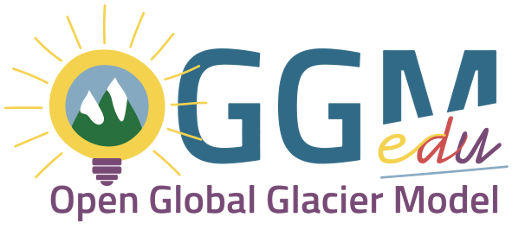

# Temperature index models

Goals of this notebook:

- gain a basic understanding of temperature index models 
- implement OGGM's temperature index model for a glacier of interest

In [1]:
import numpy as np
import oggm
from oggm import utils, cfg, workflow, tasks, graphics

In [2]:
cfg.initialize()

2019-06-02 13:30:21: oggm.cfg: Using configuration file: C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\oggm\params.cfg


Some settings:

In [3]:
# define a temporary directory to store the required data to
cfg.PATHS['working_dir'] = utils.gettempdir('ti_model')

# set the size of the local glacier map: number of grid points outside the glacier boundaries
# increasing this parameter will (significantly!) increase the amount of data that needs to be downloaded
cfg.PARAMS['border'] = 10

## 1 Background

Glacier melt significantly influences catchment hydrology. Hence, it is useful to have accurate predictions of runoff from glacierized areas. Generally, there are two classes of melt models:

- energy balance models
- temperature index models

Energy balance models are physical models quantifying melt as the residual of the energy balance equation. These models require measurements of net radiation, wind speed, temperature and surface properties to predict melt. On a glacier, spatially well resolved measurements are demanding and hard to maintain. Hence, a simpler model, the temperature index model, is the most common approach to model glacier melt.

Temperature index models assume an empirical relationship between air temperatures and melt rates and are a simplification of the energy balance models. The reasoning is that melt is predominantly influenced by the longwave atmospheric radiation and the sensible heat flux - energy balance components that are highly influenced by air temperature [(Hock, 2003)](https://www.sciencedirect.com/science/article/pii/S0022169403002579). The main reason(s) why temperature index models are commonly used are the wide availability of air temperature measurements and computational efficiency.

## 2 Model setup

The simplest temperature index model relates the amount of ice or snow melt $M$ (mm) to the sum of positive air temperatures $T^+$ ($^\circ$C) by a proportionality factor $DDF$, the *degree-day factor*, for each $n$ time intervals $\Delta t$:

$$\sum_i^{n} M = DDF \sum_i^{n} T^+ \Delta t$$

Commonly, $\Delta t = 1$ day is used - hence the name *degree-day factor*. However, any other time interval $\Delta t$, e.g. hourly or monthly, can be used to determine $DDF$. In practice, the model requires measurements of air temperature and glacier mass balance to estimate $DDF$ - once calculated, $DDF$ can be used to predict melt by only measuring air temperature [(Hock, 2003)](https://www.sciencedirect.com/science/article/pii/S0022169403002579). However, this temperature index model, also called *degree-day model*, is not able to predict glacier surface mass balance.

To model glacier surface mass balance, a more sophisticated temperature index model was developed by [Marzeion et al., (2012)](https://www.the-cryosphere.net/6/1295/2012/tc-6-1295-2012.html). The monthly mass balance $B_i$ at elevation $z$ is computed as

$$B_i(z) = P_i^{solid}(z) - \mu^* \text{max}(T_i(z) - T_{melt}, 0) - \beta^*$$

where $P_i^{Solid}$ is the monthly solid precipitation, $T_i$ the monthly average temperature, $T_{Melt}$ is the monthly average temperature above which ice melt is assumed and $\beta^*$ is a bias correction. $\mu^*$ is the temperature sensitivity of the glacier and it depends on many parameters, mostly glacier specific (e.g., avalanches, topographical shading, cloudiness, ...).

### 2.1 Degrees of freedom

Among others, the temperature sensitivity $\mu^*$, the threshold for melt $T_{Melt}$ and the implicit threshold for solid precipitation $T_{Solid}$ are important degrees of freedom of the model - $T_{Solid}$ is the monthly average temperature below which precipitation is assumed to be solid.

Generally, $T_{Melt}$ and $T_{Solid}$ can vary both spatially and temporally on a specific glacier. However, commonly the two thresholds $T_{Melt}$ and $T_{Solid}$ are assumed to be constant. $T_{Melt}$ and $T_{Solid}$ significantly influence the predicted mass balance $B$ by determining the months which are taken into account in the calculation. 

Both $T_{Melt}$ and $T_{Solid}$ can be determined by a physical reasoning: we know that both snow melts and precipitation becomes solid at around $0^{\circ}$C. Hence, the two thresholds $T_{Melt}$ and $T_{Solid}$ are within a natural range that depends on the climatological conditions at a specific glacier site.

In OGGM, $T_{Melt}$ and $T_{Solid}$ are constants and you can access the default values via the ``cfg`` module:

In [4]:
# the default temperature below which solid precipitation is assumed
print('T_solid = {}°C'.format(cfg.PARAMS['temp_all_solid']))
# the default temperature above which melt is assumed to occur
print('T_melt = {}°C'.format(cfg.PARAMS['temp_melt']))

T_solid = 0.0°C
T_melt = -1.0°C


Similarly, you can use your own $T_{Melt}$ and $T_{Solid}$ if you feel like it:

In [5]:
# don't run this ...
# cfg.PARAMS['temp_all_solid'] = 100
# cfg.PARAMS['temp_melt'] = - 273.15

The temperature sensitivity $\mu^*$ is glacier specific and mostly determined using [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS). As any other statistical method, OLS is sensitive to the sample size - a general issue in glaciology is that the sample size of annual mass balance records is poor for many glaciers. However, OLS can be used to get an estimate of $\mu^*$ if mass balance data is available.

Assume that a $100$ year long mass balance record together with temperature and precipitation measurements is available for a specific glacier (this is a best case example and only very few glaciers actually have such long records). OLS will find a statistically significant $\mu^*$ which you can happily use to model mass balance. But what happens if you only use $30$ years out of the $100$ year record for OLS? It will find another statistically significant $\mu^*$ that is different from the one determined by the $100$ year record - and another statistically significant $\mu^*$ can be found for each reasonable subset of the original $100$ year record. This implies that $\mu^*$ is generally a time dependent temperature sensitivity $\mu^*(t)$.

For this reason, OGGM implements a calibration procedure, introduced by [Marzeion et al., (2012)](https://www.the-cryosphere.net/6/1295/2012/tc-6-1295-2012.html), to determine a constant glacier specific $\mu^*$ out of the time dependent $\mu^*(t)$ candidates. This calibration is beyond the scope of this notebook and you can read about it in detail [here](https://www.the-cryosphere.net/6/1295/2012/tc-6-1295-2012.html) and check out an example implementation in OGGM [here](https://docs.oggm.org/en/stable/mass-balance.html#calibration).

## 3 Implementation in OGGM

First, we need to define a glacier directory:

In [6]:
# this may take a while
gdir = workflow.init_glacier_regions([utils.demo_glacier_id('hef')], from_prepro_level=3)[0]

2019-06-02 13:30:22: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-02 13:30:22: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2019-06-02 13:30:22: oggm.workflow: Multiprocessing: using all available processors (N=4)


If you want to look at your model domain, you can plot it using:

In [7]:
# graphics.plot_domain(gdir)

In OGGM, the calibrated temperature index model for each glacier is accessible via the ``PastMassBalance`` class of the ``massbalance`` module:

In [8]:
from oggm.core import massbalance

In [9]:
# this class is the calibrated temperature index model
mb_cal = massbalance.PastMassBalance(gdir)

In this case,

In [10]:
print('the glacier selected is {},'.format(gdir.name))

the glacier selected is Hintereisferner,


and its calibrated temperature sensitivity $\mu^*$ is

In [11]:
print('mu_star = {:2f} mm K^-1 yr^-1.'.format(mb_cal.mu_star))

mu_star = 221.275881 mm K^-1 yr^-1.


Similarly, the bias $\beta^*$ is

In [12]:
print('beta_star = {:2f} mm.'.format(mb_cal.bias))

beta_star = -2.728994 mm.


### 3.1 Climate data

Per default, the temperature index model is driven by the $0.5^{\circ} \times 0.5^{\circ}$ gridded global [CRU TS](https://crudata.uea.ac.uk/cru/data/hrg/) climate dataset. These climate data are then downscaled to a higher resolution grid to allow for an elevation-dependent dataset. Anyhow, the climate data at the reference height used to drive the temperature index model and to determine the calibrated $\mu^*$ of the selected glacier can be accessed via the glacier directory:

In [13]:
fpath = gdir.get_filepath('climate_monthly')

In [14]:
print(fpath)

C:\Users\Daniel\AppData\Local\Temp\OGGM\ti_model\per_glacier\RGI60-11\RGI60-11.00\RGI60-11.00897\climate_monthly.nc


This is the temporary path where OGGM stored its climate data on your machine. You can read the climate data using ``xarray``:

In [15]:
import xarray as xr

In [16]:
climate = xr.open_dataset(fpath)

In [17]:
print(climate)

<xarray.Dataset>
Dimensions:  (time: 1380)
Coordinates:
  * time     (time) datetime64[ns] 1901-10-01 1901-11-01 ... 2016-09-01
Data variables:
    prcp     (time) float32 ...
    temp     (time) float32 ...
Attributes:
    ref_hgt:      2700.0
    ref_pix_lon:  10.75
    ref_pix_lat:  46.750000000000014
    ref_pix_dis:  5629.5667533869655
    author:       OGGM
    author_info:  Open Global Glacier Model


The climate dataset has two variables, the monthly total precipitation ``prcp`` and the monthly average temperature ``temp``:

In [18]:
import matplotlib.pyplot as plt

C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


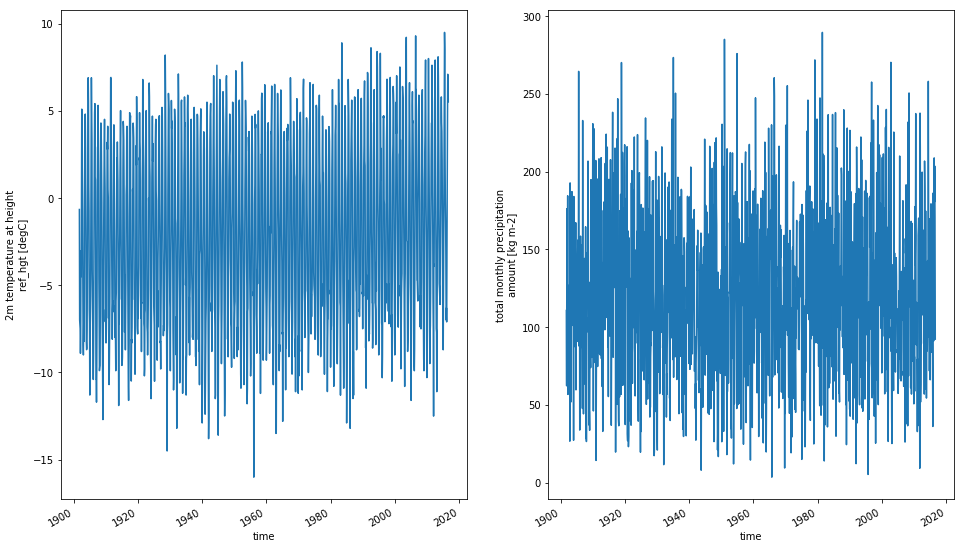

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
climate.temp.plot(ax=ax[0]);
climate.prcp.plot(ax=ax[1]);

Pretty noisy. Let's calculate annual averages and annual sums for temperature and precipitation respectively:

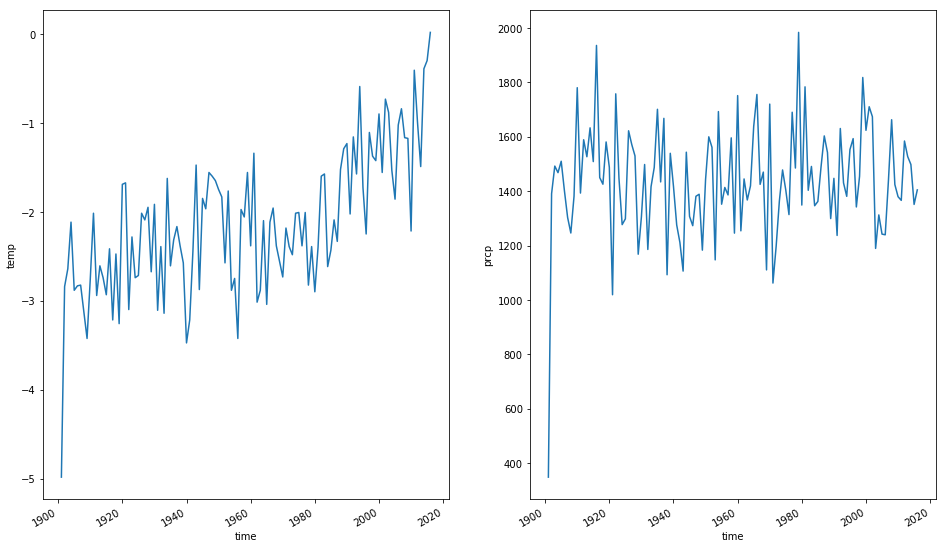

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
climate.temp.resample(time='AS').mean().plot(ax=ax[0]);
climate.prcp.resample(time='AS').sum().plot(ax=ax[1]);

Much better.

### 3.2 Reference mass balance data

OGGM uses in-situ mass balance data from the World Glacier Monitoring Service Fluctuations of Glaciers Database [(WGMS FoGD)](https://wgms.ch/data_databaseversions/). The Fluctuations of Glaciers (FoG) database contains annual mass-balance values for several hundreds of glaciers worldwide. Currently, 254 mass balance time series are available.

These data are shipped automatically with OGGM and can be accessed via the glacier directory:

In [21]:
# Get the reference mass-balance from the WGMS FoG Database
ref_mb = gdir.get_ref_mb_data()

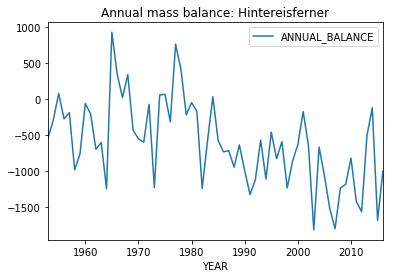

In [22]:
ref_mb[['ANNUAL_BALANCE']].plot(title='Annual mass balance: {}'.format(gdir.name));

### 3.3 Predict mass balance!

Now, we are set to calculate glacier mass balance using the temperature index model - we have the model parameters $\mu^*$ and $\beta^*$, the thresholds for melt and solid precipitation $T_{Melt}$ and $T_{Solid}$ and the climate dataset. The last thing we need to define are the heights at which we want to calculate the mass balance. Here, we use glacier flowlines along which the mass balance is computed:

In [23]:
# I need some help explaining the concept of flowlines in more detail if required

In [24]:
fls = gdir.read_pickle('inversion_flowlines')

We will calculate the specific mass balance in mm w.e. yr$^{-1}$ for the years where in-situ mass balance data is available:

In [25]:
print(ref_mb.index.values)

[1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966
 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016]


The specific mass balance along the given flowlines is computed by

In [26]:
ref_mb['OGGM (calib)'] = mb_cal.get_specific_mb(fls=fls, year=ref_mb.index.values)

For this calculation we assumed an average ice density of

In [27]:
print('rho_ice = {} kg m^-3.'.format(cfg.PARAMS['ice_density']))

rho_ice = 900.0 kg m^-3.


Now, we can compare the actual in-situ mass balance with the modelled mass balance:

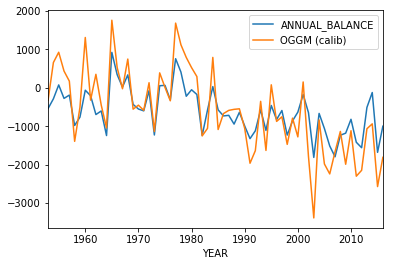

In [28]:
ref_mb[['ANNUAL_BALANCE', 'OGGM (calib)']].plot();

Does not look too bad, does it? To assess model performance, it is helpful to plot the data in a scatter plot:

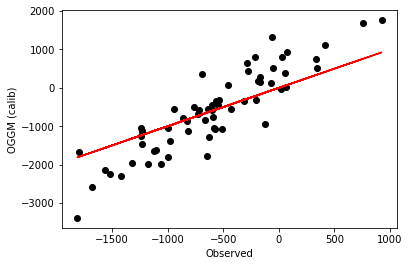

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(ref_mb['ANNUAL_BALANCE'], ref_mb['OGGM (calib)'], 'ok');
ax.plot(ref_mb['ANNUAL_BALANCE'], ref_mb['ANNUAL_BALANCE'], '-r')
ax.set_xlabel('Observed');
ax.set_ylabel('OGGM (calib)');

In [30]:
# model overestimates extreme events ? 

If the points were aligned along the red line, the model would perfectly predict mass balance.

## Take home points

- There are two different types of melt models: the energy balance model and the temperature index model
- The temperature index model is the computationally efficient simplification of the energy balance model
- Temperature index models assume an empirical relationship between air temperature and melt rates
- Temperature index models can be extended to model glacier mass balance by adding solid precipitation as a model parameter
- The model outcome is significantly influenced by the choice of $T_{Melt}$ and $T_{Solid}$
- The temperature sensitivity of a glacier is not constant in time $\mu^* = \mu^*(t)$

## References

- Hock R., (2003). Temperature index melt modelling in mountain areas. *Journal of Hydrology*, 281, 104-115. https://doi.org/10.1016/S0022-1694(03)00257-9
- Marzeion B., Jarosch A. H. & Hofer M. (2012). Past and future sea-level change from the surface mass balance of glaciers. *The Cryosphere*, 6, 1295-1322. https://doi.org/10.5194/tc-6-1295-2012

## What's next?

[Back to table of contents](welcome.ipynb)